### üå™Ô∏è Proyecto de Predicci√≥n de Magnitud de Tornados con LSTM
- Fuente: kaggle.com
- URL: https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021
- Fecha: 30 de Abril del 2025

#### üéØ Objetivo del Proyecto
Desarrollar un modelo de **Machine Learning** utilizando redes neuronales **LSTM** (*Long Short-Term Memory*) para predecir la magnitud de tornados en EE.UU.

#### üìÅ Dataset Utilizado `us_tornado_dataset.csv`
**Contenido principal del dataset:**
- üìÖ Fecha del evento
- üó∫Ô∏è Estado afectado (ubicaci√≥n geogr√°fica)
- üè• N√∫mero de heridos y fallecidos
- üìç Coordenadas de inicio/fin (latitud, longitud)
- üìè Longitud y ancho del tornado
- ‚ö° Magnitud (Escala Fujita Mejorada - EF)

#### ü§ñ Por qu√© LSTM?
| Caracter√≠stica | Beneficio para el Proyecto |
|---------------|---------------------------|
| üï∞Ô∏è Manejo de secuencias temporales | Ideal para analizar evoluci√≥n hist√≥rica de tornados |
| üß† Memoria a largo plazo | Detecta patrones complejos en series de tiempo |
| üåê Capacidad espacial | Puede aprender de coordenadas geogr√°ficas |


### 0. Librer√≠as

In [2]:
# 1. Librer√≠as b√°sicas y manejo de datos
import pickle
import logging
import pandas as pd
import numpy as np

# 2. Visualizaci√≥n de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster

# 3. Preprocesamiento y feature engineering
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV

)
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.pipeline import Pipeline

# 4. Modelos de Machine Learning
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier

# 5. Evaluaci√≥n de modelos
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# 6. Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

2025-04-30 21:16:00.730015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 21:16:00.986620: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 21:16:01.106642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746047761.386631    9267 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746047761.477039    9267 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746047762.125560    9267 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### 1. Introducci√≥n

En este proyecto desarrollaremos un modelo de aprendizaje autom√°tico utilizando redes neuronales LSTM (Long Short-Term Memory) para predecir la magnitud de tornados en Estados Unidos, bas√°ndonos en un conjunto de datos hist√≥ricos llamado us_tornado_dataset_1950_2021.csv. Este dataset incluye informaci√≥n relevante sobre cada evento de tornado, como la fecha, el estado afectado, n√∫mero de heridos y fallecidos, coordenadas de inicio y fin, longitud y ancho del tornado.

El objetivo principal es construir un modelo capaz de aprender patrones temporales y espaciales a partir de estos datos, permitiendo realizar predicciones m√°s precisas sobre la magnitud de futuros tornados. Las redes LSTM son especialmente √∫tiles para este tipo de problemas, ya que est√°n dise√±adas para trabajar con secuencias de datos y capturar relaciones de largo plazo, lo que resulta ideal en contextos donde la evoluci√≥n temporal de los eventos es relevante.

### 2. Conceptos (Marco te√≥rico)

#### üå™Ô∏è Tornados: Definici√≥n, Clasificaci√≥n e Impacto

#### ‚ùì ¬øQu√© es un tornado?
**Un tornado** es una columna de aire que gira violentamente desde una tormenta el√©ctrica hasta la superficie terrestre.  

**Caracter√≠sticas principales:**  
- Forma de embudo caracter√≠stica  
- Vientos extremadamente fuertes  
- Causa da√±os severos en su trayectoria  
- Var√≠a en intensidad, tama√±o y duraci√≥n  

**Formaci√≥n:**  
Requiere condiciones atmosf√©ricas espec√≠ficas:  
‚úî Humedad  
‚úî Inestabilidad del aire  
‚úî Cizalladura del viento  

---

#### üìä Clasificaci√≥n: Escala Fujita Mejorada (EF)
Sustituy√≥ en 2007 a la Escala Fujita original (1971) por mayor precisi√≥n.

| Categor√≠a | Velocidad Viento | Da√±os |
|-----------|------------------|-------|
| **EF0** | 65-85 mph (105-137 km/h) | Leves (ramas rotas) |
| **EF1** | 86-110 mph (138-177 km/h) | Moderados (tejados da√±ados) |
| **EF2** | 111-135 mph (178-217 km/h) | Considerables (√°rboles arrancados) |
| **EF3** | 136-165 mph (218-266 km/h) | Graves (paredes derrumbadas) |
| **EF4** | 166-200 mph (267-322 km/h) | Devastadores (casas destruidas) |
| **EF5** | >200 mph (322+ km/h) | Incre√≠bles (estructuras niveladas) |

---

#### üí∞ Impacto Econ√≥mico
**Factores clave:**  
- **Categor√≠a del tornado** (EF3+ = mayor destrucci√≥n)  
- **Ubicaci√≥n** (zonas urbanas = mayor costo)  

**√Åreas afectadas:**  
- üè† Viviendas e infraestructuras  
- üåæ Agricultura (cosechas/ganado)  
- üè¢ Negocios (interrupciones operativas)  
- üöë Respuesta de emergencia  

#### üìå Ejemplos destacados (EE.UU.)
| Evento | A√±o | Da√±os (USD) | Categor√≠a |
|--------|-----|-------------|-----------|
| Joplin, MO | 2011 | $2.8 mil millones | EF5 |
| Moore, OK | 2013 | $2 mil millones | EF5 |
| **Promedio anual (1996-2023)** | - | **$1.1 mil millones** | EF3-EF4 |  


> **Dato cr√≠tico:** Un EF2 en zona urbana puede costar m√°s que un EF4 en √°rea rural.

#### Algoritmo LSTM (Long Short-Term Memory)

##### üìå Definici√≥n
**LSTM** es un tipo especial de Red Neuronal Recurrente (RNN) dise√±ada para manejar dependencias de **largo plazo** en datos secuenciales, resolviendo el problema del *vanishing gradient* (desvanecimiento del gradiente) de las RNN tradicionales.

#### üß† Estructura Clave
#### 1. **Celda de Memoria**
   - Almacena informaci√≥n relevante por largos per√≠odos.

#### 2. **Tres Puertas Reguladoras**
| Puerta             | Funci√≥n                                                                 |
|--------------------|-------------------------------------------------------------------------|
| **Forget Gate**    | Decide qu√© informaci√≥n se descarta de la celda de memoria.              |
| **Input Gate**     | Actualiza la celda con nueva informaci√≥n importante.                   |
| **Output Gate**    | Controla qu√© informaci√≥n pasa al siguiente paso en la secuencia.       |

#### üöÄ Aplicaciones Comunes
- üìà Predicci√≥n de series temporales (mercado burs√°til, clima)
- üí¨ Procesamiento de Lenguaje Natural (traducci√≥n, chatbots)
- üé§ Reconocimiento de voz y video

#### ‚úÖ Ventajas
‚úî Maneja secuencias m√°s largas que RNN est√°ndar  
‚úî Evita el desvanecimiento del gradiente  
‚úî Captura patrones temporales complejos

#### ‚öôÔ∏è Ejemplo en Keras
```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(10, 1)),  # Capa LSTM
    LSTM(units=32),
    Dense(1)  # Capa de salida
])
model.compile(optimizer='adam', loss='mse')

#### Diccionario de Datos


|Nombre|Descripci√≥n|Tipo|
|----|-----------|----|
|year|A√±o con 4 d√≠gitos|Int|
|month|Mes (1-12)|Int|
|day|D√≠a del mes|Int|
|date|Objeto datetime (ej. 2011-01-01)|Date|
|state|Estado donde se origin√≥ el tornado; abreviatura de 2 letras|String|
|magnitude|Escala Fujita mejorada para clasificar tornados|Int|
|injuries|N√∫mero de heridos durante el tornado|Int|
|fatalities|N√∫mero de fallecidos durante el tornado|Int|
|start_latitude|Latitud inicial en grados decimales|Float|
|start_longitude|Longitud inicial en grados decimales|Float|
|end_latitude|Latitud final en grados decimales|Float|
|end_longitude|Longitud final en grados decimales|Float|
|length|Longitud de la trayectoria en millas|Float|
|width|Ancho en yardas|Float|

### 3. Hip√≥tesis

En este proyecto desarrollaremos un modelo de aprendizaje autom√°tico utilizando redes neuronales LSTM (Long Short-Term Memory) para predecir la magnitud de tornados en Estados Unidos, bas√°ndonos en un conjunto de datos hist√≥ricos llamado us_tornado_dataset.csv. Este dataset incluye informaci√≥n relevante sobre cada evento de tornado, como la fecha, el estado afectado, n√∫mero de heridos y fallecidos, coordenadas de inicio y fin, longitud y ancho del tornado.

El objetivo principal es construir un modelo capaz de aprender patrones temporales y espaciales a partir de estos datos, permitiendo realizar predicciones m√°s precisas sobre la magnitud de futuros tornados. Las redes LSTM son especialmente √∫tiles para este tipo de problemas, ya que est√°n dise√±adas para trabajar con secuencias de datos y capturar relaciones de largo plazo, lo que resulta ideal en contextos donde la evoluci√≥n temporal de los eventos es relevante.

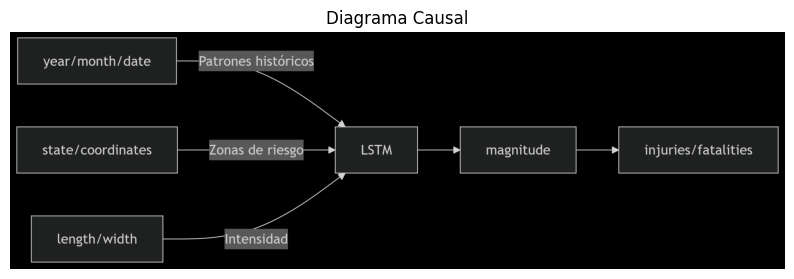

In [2]:
diag_causal = mpimg.imread('../diagrama_causal.png') 

# Mostrar imagen
plt.figure(figsize=(10, 6))  
plt.imshow(diag_causal)
plt.axis('off') 
plt.title('Diagrama Causal')
plt.show()

### 4. Preprocesamiento

In [3]:
df_raw = pd.read_csv('../data/raw/us_tornado_dataset_1950_2021.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67558 entries, 0 to 67557
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      67558 non-null  int64  
 1   mo      67558 non-null  int64  
 2   dy      67558 non-null  int64  
 3   date    67558 non-null  object 
 4   st      67558 non-null  object 
 5   mag     67558 non-null  int64  
 6   inj     67558 non-null  int64  
 7   fat     67558 non-null  int64  
 8   slat    67558 non-null  float64
 9   slon    67558 non-null  float64
 10  elat    67558 non-null  float64
 11  elon    67558 non-null  float64
 12  len     67558 non-null  float64
 13  wid     67558 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 7.2+ MB


In [4]:
df_raw.sample(10, random_state=2025)

yr  mo  dy        date  st  mag  inj  fat   slat    slon   elat  \
44528  2003   6   4  2003-06-04  NM    0    0    0  36.65 -104.13  36.65   
25316  1985   8  31  1985-08-31  FL    1    0    0  28.25  -82.72   0.00   
31651  1992   8  29  1992-08-29  FL    0    0    0  26.68  -80.05   0.00   
23045  1983   4  23  1983-04-23  WA    0    0    0  46.90 -119.07   0.00   
47201  2005   5  11  2005-05-11  IL    0    0    0  40.00  -91.17  40.00   
51002  2008   5   5  2008-05-05  TX    0    0    0  31.28 -102.65  31.31   
17846  1977   4  19  1977-04-19  TX    0    0    0  33.85  -98.83   0.00   
50080  2007   6  29  2007-06-29  CO    0    0    0  38.04 -105.47  38.03   
24505  1984   7   5  1984-07-05  MA    1    0    0  42.50  -72.33   0.00   
26125  1986  10   1  1986-10-01  WV    3    1    0  39.30  -80.78   0.00   

         elon   len  wid  
44528 -104.13  0.50  100  
25316    0.00  0.50   10  
31651    0.00  0.10   10  
23045    0.00  0.50   33  
47201  -91.17  0.20   50  
51002 -102.63  2.28   50  
17846    0.00  0.10   10  
50080 -105.47  1.00   75  
24505    0.00  2.00   80  
26125    0.00  1.00  200

In [5]:
df_baking = df_raw.copy()
df_baking = df_baking[df_baking['date'] > "2007-01-31"] #Tomamos la data de Febrero 2007 en adelante
df_baking = df_baking[(df_baking['mag'] != -9) & (df_baking['mag'] != 5) & (df_baking['mag'] !=4)] #Eliminamos filas sin magnitud y magnitud 4 y 5
#df_baking = df_baking[(df_baking['st'] != 'VI') & (df_baking['st'] != 'DC') & (df_baking['st'] != 'PR') & (df_baking['st'] != 'HI') & (df_baking['st'] != 'AL') ] #Eliminamos outliers de Estado
conteo_states = df_baking['st'].value_counts()
estados_validos = conteo_states[conteo_states >= 50].index
df_baking = df_baking[df_baking['st'].isin(estados_validos)]
df_baking = df_baking[(df_baking['len'] != 0) & (df_baking['wid'] != 0) & (df_baking["elat"] != 0)] ##Eliminamos filas sin trayecto o ancho conocidos
df_baking.drop_duplicates(inplace=True) #Eliminamos filas duplicadas
df_baking['date'] = pd.to_datetime(df_baking['date']) #Convertimos columna date en tipo Date
df_baking = df_baking.sort_values('date') #Ordenamos por orden cronologico
df_baking.reset_index(drop=True, inplace=True) #Reinciamos Indices 
df_baking.rename(columns={"yr": "year", "mo": "month", "dy": "day", "date": "date", "st": "state", "mag": "magnitude",
                          "inj": "injuries", "fat": "fatalities", "slat": "start_latitude", "slon": "start_longitude",
                          "elat": "end_latitude", "elon": "end_longitude","len": "length", "wid": "width"}, inplace=True)

#CREATING NEW COLUMN FOR US REGION
ne = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
s = ['DE', 'MD', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'KY', 'TN', 'AL', 'MS', 'LA', 'TX','DC']
mw = ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
w = ['AZ', 'CA', 'CO', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

regions = []


for state in df_baking['state']:
    if state in ne:
        region = 'e'
    elif state in s:
        region = 's'
    elif state in mw:
        region = 'mw'
    elif state in w:
        region = 'w'
    else:
        region = 'Unknown'  # For states not in any region

    regions.append(region)

df_baking['region'] = regions

###
#Months into seasons:
Winter = (12, 1, 2)
Spring = (3, 4, 5)
Summer = (6, 7, 8)
Fall = (9, 10, 11)
seasons = []
for month in df_baking['month']:
    if month in Winter:
        current_season = 'Winter'
    elif month in Spring:
        current_season = 'Spring'
    elif month in Summer:
        current_season = 'Summer'
    elif month in Fall:
        current_season = 'Fall'
    else:
        current_season = 'Unknown'
    seasons.append(current_season)
df_baking['season'] = seasons
df_baking['season'] = df_baking['season'].astype('category')
###

df_baking['magnitude'] = df_baking['magnitude'].astype('category')
df_baking['state'] = df_baking['state'].astype('category')
df_baking['region'] = df_baking['region'].astype('category')
df_baking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   year             16880 non-null  int64         
 1   month            16880 non-null  int64         
 2   day              16880 non-null  int64         
 3   date             16880 non-null  datetime64[ns]
 4   state            16880 non-null  category      
 5   magnitude        16880 non-null  category      
 6   injuries         16880 non-null  int64         
 7   fatalities       16880 non-null  int64         
 8   start_latitude   16880 non-null  float64       
 9   start_longitude  16880 non-null  float64       
 10  end_latitude     16880 non-null  float64       
 11  end_longitude    16880 non-null  float64       
 12  length           16880 non-null  float64       
 13  width            16880 non-null  int64         
 14  region           16880 non-null  categ

In [6]:
df = df_baking.copy()

### 5. An√°lisis Exploratorio de Datos

In [ ]:
df_train = df.iloc[:14741,:] # 85% del dataset para df_train
df_val = df.iloc[14741:15800,:] # 7.5% del dataset para df_val
df_test = df.iloc[15800:,:] # 7.5% del dataset para df_test

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((14741, 16), (1059, 16), (1080, 16))

<Axes: title={'center': 'Frcuencia de Tornados por Mes'}, xlabel='month'>

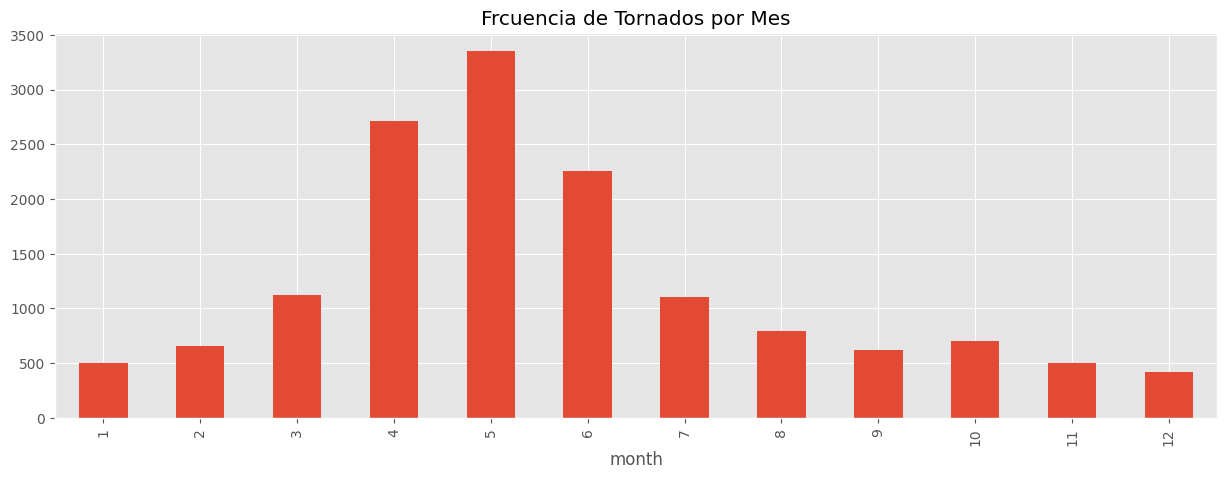

In [17]:
plt.style.use('ggplot');
plt.title('Frcuencia de Tornados por Mes')
df_train['month'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

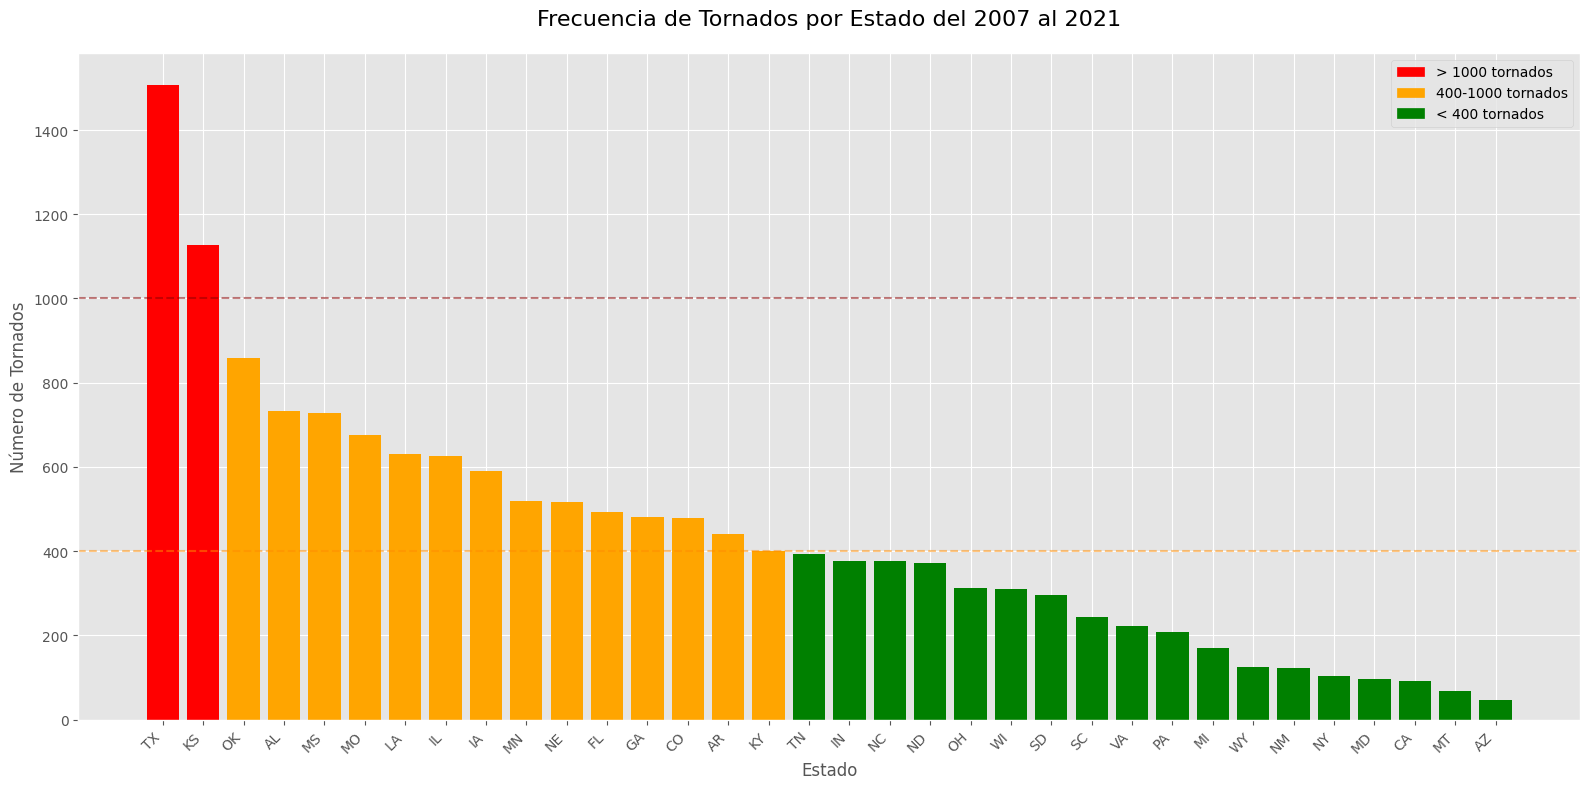

In [18]:
state_counts = df_train['state'].value_counts().sort_values(ascending=False)

colors = []
for count in state_counts:
    if count > 1000:
        colors.append('red')
    elif 400 <= count <= 1000:
        colors.append('orange')
    else:
        colors.append('green')

plt.figure(figsize=(16, 8))
bars = plt.bar(state_counts.index, state_counts.values, color=colors)

plt.title('Frecuencia de Tornados por Estado del 2007 al 2021', fontsize=16, pad=20)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('N√∫mero de Tornados', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.axhline(y=1000, color='darkred', linestyle='--', alpha=0.5)
plt.axhline(y=400, color='darkorange', linestyle='--', alpha=0.5)

legend_elements = [
    mpatches.Patch(color='red', label='> 1000 tornados'),
    mpatches.Patch(color='orange', label='400-1000 tornados'),
    mpatches.Patch(color='green', label='< 400 tornados')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
# Filtrar por a√±o
year_filter  = 2019
df_filtered = df_train[df_train['year'] == year_filter].copy()  # Cambia el a√±o seg√∫n necesites

# Mapa
map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Agrupamiento de marcadores
marker_cluster = MarkerCluster().add_to(map)

# A√±adir elementos en lotes o grupos
for coords in df_filtered[['start_latitude', 'start_longitude']].values:
    folium.CircleMarker(
        location=coords,
        radius=3,
        color='green',
        fill=True
    ).add_to(marker_cluster)

for coords in df_filtered[['end_latitude', 'end_longitude']].values:
    folium.CircleMarker(
        location=coords,
        radius=3,
        color='red',
        fill=True
    ).add_to(marker_cluster)

#L√≠neas de trayectoria
for _, row in df_filtered.iterrows():
    folium.PolyLine(
        locations=[(row['start_latitude'], row['start_longitude']), 
                  (row['end_latitude'], row['end_longitude'])],
        color='blue',
        weight=1
    ).add_to(map)

map

### 6. Desarrollo del modelo de machine learning - LSTM

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14741 entries, 0 to 14740
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   year             14741 non-null  int64         
 1   month            14741 non-null  int64         
 2   day              14741 non-null  int64         
 3   date             14741 non-null  datetime64[ns]
 4   state            14741 non-null  category      
 5   magnitude        14741 non-null  category      
 6   injuries         14741 non-null  int64         
 7   fatalities       14741 non-null  int64         
 8   start_latitude   14741 non-null  float64       
 9   start_longitude  14741 non-null  float64       
 10  end_latitude     14741 non-null  float64       
 11  end_longitude    14741 non-null  float64       
 12  length           14741 non-null  float64       
 13  width            14741 non-null  int64         
 14  region           14741 non-null  categ

In [20]:
# Codificar 'magnitude' usando LabelEncoder
label_encoder = LabelEncoder()

df_train.loc[:, 'magnitude_encoded'] = label_encoder.fit_transform(df_train['magnitude'])
df_val.loc[:, 'magnitude_encoded'] = label_encoder.transform(df_val['magnitude'])
df_test.loc[:, 'magnitude_encoded'] = label_encoder.transform(df_test['magnitude'])

# Codificar 'month' usando OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

df_train.loc[:, 'month_encoded'] = ordinal_encoder.fit_transform(df_train[['month']])
df_val.loc[:, 'month_encoded'] = ordinal_encoder.transform(df_val[['month']])
df_test.loc[:, 'month_encoded'] = ordinal_encoder.transform(df_test[['month']])

# Codificar 'season' usando OrdinalEncoder
df_train.loc[:, 'season_encoded'] = ordinal_encoder.fit_transform(df_train[['season']])
df_val.loc[:, 'season_encoded'] = ordinal_encoder.transform(df_val[['season']])
df_test.loc[:, 'season_encoded'] = ordinal_encoder.transform(df_test[['season']])

# Codificar 'region' usando OrdinalEncoder
df_train.loc[:, 'region_encoded'] = ordinal_encoder.fit_transform(df_train[['region']])
df_val.loc[:, 'region_encoded'] = ordinal_encoder.transform(df_val[['region']])
df_test.loc[:, 'region_encoded'] = ordinal_encoder.transform(df_test[['region']])




# Verifica que las columnas se hayan agregado correctamente
print(df_train[['magnitude', 'magnitude_encoded', 'month', 'month_encoded']].head())

# Caracter√≠sticas a escalar (sin la columna 'month' original)
features = ['month_encoded', 'start_latitude', 'start_longitude','length', 'width']

# Escalamos las caracter√≠sticas
scaler = MinMaxScaler()

# Escalar los datos (fit en el set de entrenamiento y transformar en el de validaci√≥n y test)
train_scaled = scaler.fit_transform(df_train[features])  # solo fit en el set de entrenamiento
val_scaled = scaler.transform(df_val[features])
test_scaled = scaler.transform(df_test[features])

  magnitude  magnitude_encoded  month  month_encoded
0         0                  0      2            1.0
1         1                  1      2            1.0
2         3                  3      2            1.0
3         3                  3      2            1.0
4         1                  1      2            1.0


/tmp/ipykernel_58313/3778704670.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'magnitude_encoded'] = label_encoder.fit_transform(df_train['magnitude'])
/tmp/ipykernel_58313/3778704670.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'magnitude_encoded'] = label_encoder.transform(df_val['magnitude'])
/tmp/ipykernel_58313/3778704670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [23]:
def secuencias(dataset, n_steps):
    X = []
    for i in range(len(dataset) - n_steps):
        X.append(dataset[i:i+n_steps, :])  
    return np.array(X)

In [24]:
# Crear las secuencias (X, y) para entrenamiento, validaci√≥n y test
n_steps = 20  # N√∫mero de filas  para las secuencias
X_train = secuencias(train_scaled, n_steps)
X_val = secuencias(val_scaled, n_steps)
X_test = secuencias(test_scaled, n_steps)

# Asignar las etiquetas (magnitude_encoded) como target
y_train = df_train['magnitude_encoded'].values[n_steps:]
y_val = df_val['magnitude_encoded'].values[n_steps:]
y_test = df_test['magnitude_encoded'].values[n_steps:]

In [25]:
# Calcular los pesos para las clases de y_train
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)

# Convertir a diccionario para usarlo en el modelo
class_weight_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weight_dict)

Pesos de clase: {0: np.float64(0.4565500558243394), 1: np.float64(0.7375250501002004), 2: np.float64(2.7775471698113208), 3: np.float64(10.667391304347825)}


In [37]:
# Crear el modelo
lstm_tornado = Sequential()

# Capa de entrada: (n_steps, 3 features)
lstm_tornado.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # (20, 3)

# Capa LSTM
lstm_tornado.add(LSTM(units=100, return_sequences=False))

# Capa Dropout para evitar sobreajuste
lstm_tornado.add(Dropout(0.2))

# N√∫mero de clases (magnitudes √∫nicas)
n_classes = len(np.unique(y_train))

# Capa de salida: clasificaci√≥n multiclase
lstm_tornado.add(Dense(n_classes, activation='softmax'))  # Softmax para clasificaci√≥n

# Resumen del modelo
lstm_tornado.summary()


2025-04-29 03:00:22.923514: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm (LSTM)                     ‚îÇ (None, 100)            ‚îÇ        42,400 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 100)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 4)              ‚îÇ           404 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 42,804 (167.20 KB)

 Trainable params: 42,804 (167.20 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compilar el modelo
lstm_tornado.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy',  # Correcto para y en formato entero
                     metrics=['accuracy'])


In [41]:
# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo

y_hat_lstm = lstm_tornado.fit(X_train, y_train, 
                              epochs=50, 
                              batch_size=32, 
                              validation_data=(X_val, y_val), 
                              callbacks=[early_stop],
                              class_weight=class_weight_dict)


Epoch 1/50
461/461 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 14ms/step - accuracy: 0.2951 - loss: 1.3883 - val_accuracy: 0.4720 - val_loss: 1.2873
Epoch 2/50
461/461 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 12ms/step - accuracy: 0.4001 - loss: 1.3356 - val_accuracy: 0.3771 - val_loss: 1.3290
Epoch 3/50
461/461 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 13ms/step - accuracy: 0.4017 - loss: 1.3530 - val_accuracy: 0.3212 - val_loss: 1.3848
Epoch 4/50
461/461 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 13ms/step - accuracy: 0.4331 - loss: 1.3194 - val_accuracy: 0.4453 - val_loss: 1.2838
Epoch 5/50
461/461 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 8ms/step - accuracy: 0.4423 - loss: 1.3388 - val_accuracy: 0.4688 - val_loss: 1.2419
Epoch 6/50
461/461 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 9ms/step - accuracy: 0.4599 - loss: 1.2896 - val_accuracy: 0.3544 - val_l

In [42]:
# Evaluar el modelo en el conjunto de test
test_loss, test_acc = lstm_tornado.evaluate(X_test, y_test)

# Imprimir la p√©rdida y precisi√≥n en el conjunto de test
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")


29/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - accuracy: 0.4546 - loss: 1.2494

39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step - accuracy: 0.4637 - loss: 1.2435
Test loss: 1.2408071756362915
Test accuracy: 0.47811993956565857


In [43]:
# Predicciones sobre el conjunto de test
y_hat_lstm = lstm_tornado.predict(X_test)
y_hat_class = np.argmax(y_hat_lstm, axis=1)  # Para obtener las clases predichas

# Imprimir el reporte de clasificaci√≥n
print("Modelo LSTM")
print(classification_report(y_test, y_hat_class))

39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step
Modelo LSTM
              precision    recall  f1-score   support

           0       0.62      0.52      0.57       623
           1       0.45      0.47      0.46       479
           2       0.22      0.33      0.27       111
           3       0.11      0.24      0.15        21

    accuracy                           0.48      1234
   macro avg       0.35      0.39      0.36      1234
weighted avg       0.51      0.48      0.49      1234



In [ ]:
# Restaurar 'magnitude'
df_train['magnitude'] = label_encoder.inverse_transform(df_train['magnitude_encoded'])
df_val['magnitude'] = label_encoder.inverse_transform(df_val['magnitude_encoded'])
df_test['magnitude'] = label_encoder.inverse_transform(df_test['magnitude_encoded'])


/tmp/ipykernel_38728/1512388511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['magnitude'] = label_encoder.inverse_transform(df_train['magnitude_encoded'])
/tmp/ipykernel_38728/1512388511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['magnitude'] = label_encoder.inverse_transform(df_val['magnitude_encoded'])
/tmp/ipykernel_38728/1512388511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

26/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step

39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step


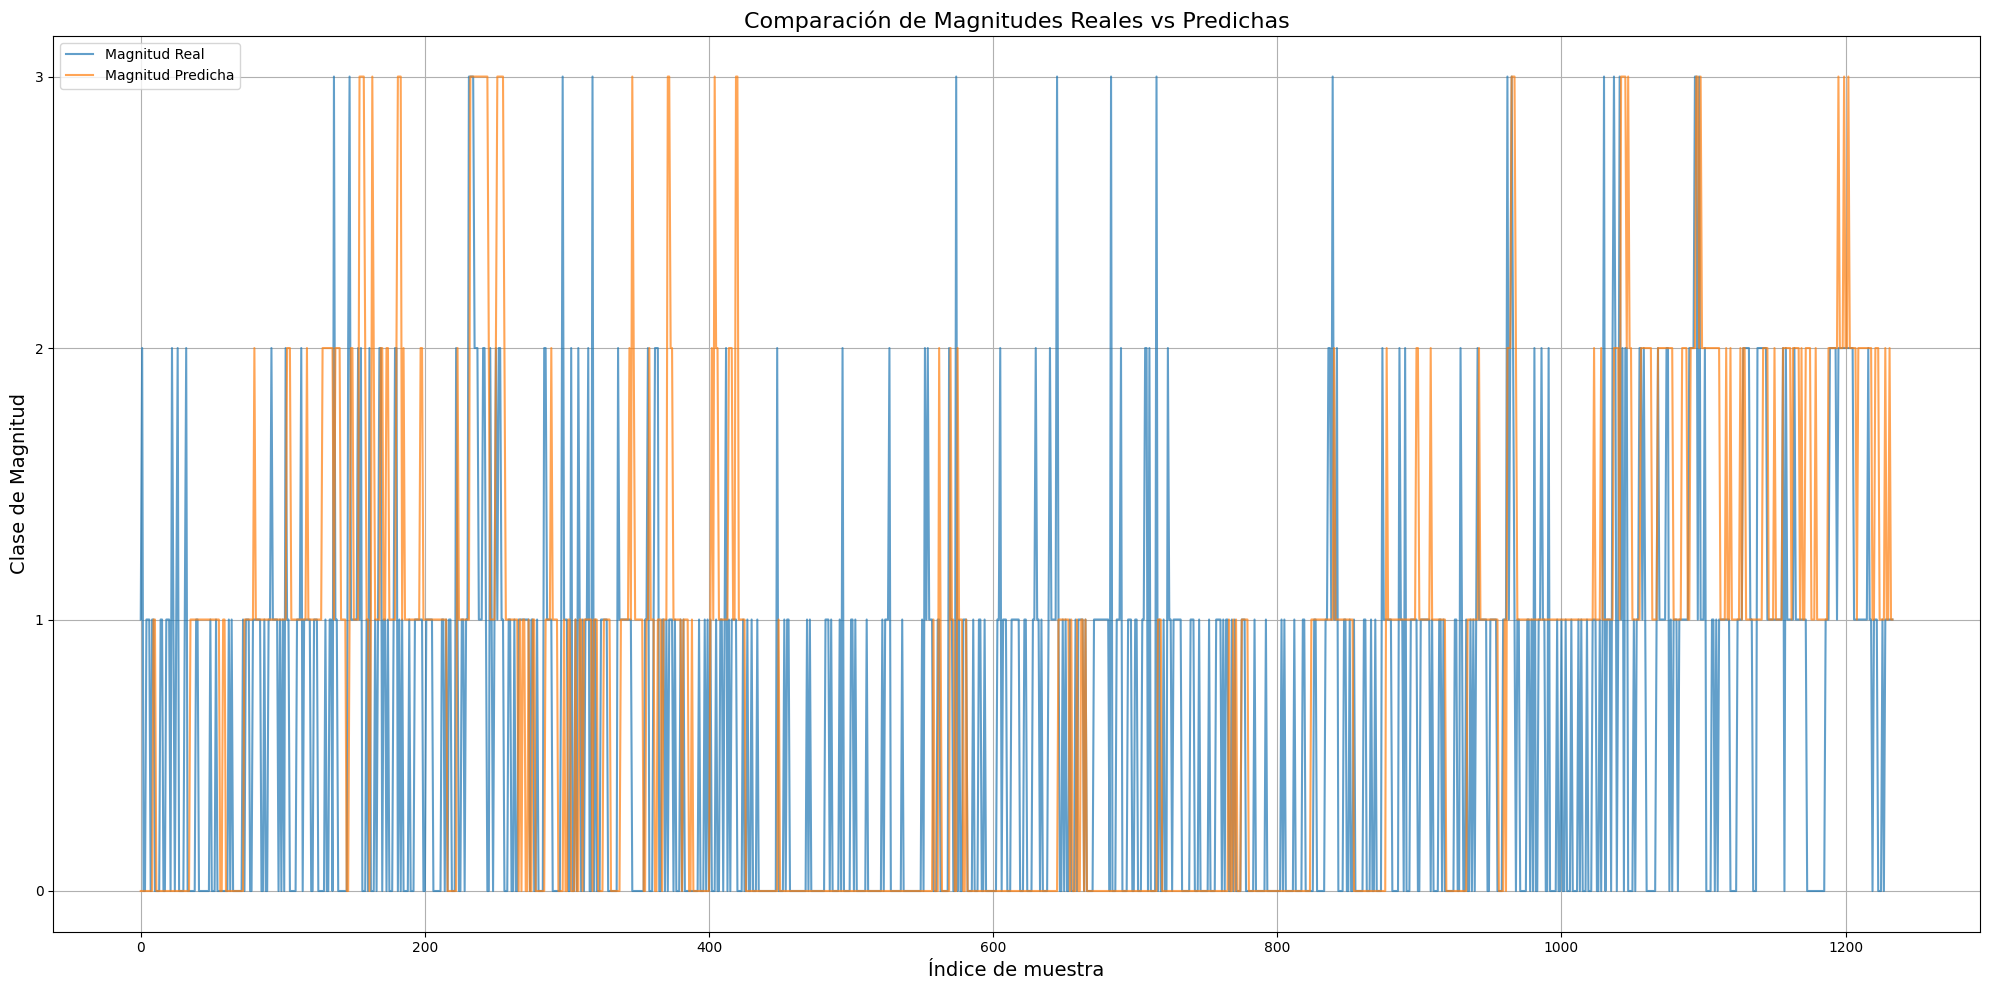

In [50]:
# Predicciones sobre el conjunto de test
predicciones = lstm_tornado.predict(X_test)

# Convertir predicciones probabil√≠sticas a clases
y_hat_classes = np.argmax(predicciones, axis=1)

# Crear el gr√°fico
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Magnitud Real', alpha=0.7)
plt.plot(y_hat_classes, label='Magnitud Predicha', alpha=0.7)
plt.title('Comparaci√≥n de Magnitudes Reales vs Predichas', fontsize=16)
plt.xlabel('√çndice de muestra', fontsize=14)
plt.ylabel('Clase de Magnitud', fontsize=14)

# Escala en el eje Y en pasos de 1
plt.yticks(np.arange(min(y_test.min(), y_hat_classes.min()), 
                     max(y_test.max(), y_hat_classes.max()) + 1, 
                     1))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7. Comparacion de modelos

#### Gradient Boosting

In [8]:
df = df_baking.copy()

In [9]:
#Train + Temp (val + test)
df_train, df_temp = train_test_split(df, test_size=0.2,
                                     random_state=2025,
                                     stratify=df['magnitude'])

#Val + Test
df_val, df_test = train_test_split(df_temp, test_size=0.5,
                                   random_state=2025,
                                   stratify=df_temp['magnitude'])

#Reindexado
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape)

(13504, 16) (1688, 16) (1688, 16)


In [10]:
df_train_gb = df_train.copy()
df_val_gb = df_val.copy()
df_test_gb = df_test.copy()

# Columnas categ√≥ricas que vamos a codificar
categorical_cols = ['month', 'state', 'region', 'season']

# Crear y aplicar el OrdinalEncoder
ordinal_encoder_gb = OrdinalEncoder()

# Fit en entrenamiento, transform en los 3 conjuntos
df_train_gb[categorical_cols] = ordinal_encoder_gb.fit_transform(df_train_gb[categorical_cols])
df_val_gb[categorical_cols]   = ordinal_encoder_gb.transform(df_val_gb[categorical_cols])
df_test_gb[categorical_cols]  = ordinal_encoder_gb.transform(df_test_gb[categorical_cols])

In [33]:
# Variables
categorical_cols = ['month', 'state', 'region', 'season']
numeric_cols = ['start_latitude', 'start_longitude', 'length', 'width']
target = 'magnitude'

# Columnas finales para el modelo
feature_cols = categorical_cols + numeric_cols

# Sets de entrenamiento, validaci√≥n y prueba
X_train_gb = df_train_gb[feature_cols]
y_train_gb = df_train_gb[target]

X_val_gb = df_val_gb[feature_cols]
y_val_gb = df_val_gb[target]

X_test_gb = df_test_gb[feature_cols]
y_test_gb = df_test_gb[target]

In [34]:
# Calcular los pesos por clase
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_gb),
                                     y=y_train_gb)

# Convertir a diccionario
class_weight_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weight_dict)

# Generar pesos para cada muestra del set de entrenamiento
sample_weights = compute_sample_weight(class_weight=class_weight_dict, y=y_train_gb)

# Definir y entrenar el modelo base
clf_gb = HistGradientBoostingClassifier(random_state=2025)
clf_gb.fit(X_train_gb, y_train_gb, sample_weight=sample_weights)

Pesos de clase: {0: np.float64(0.4638636988183567), 1: np.float64(0.7202901642841903), 2: np.float64(2.7536704730831976), 3: np.float64(10.78594249201278)}


HistGradientBoostingClassifier(random_state=2025)

Reporte de Clasificaci√≥n (Modelo Base Gradient Boosting):
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       910
           1       0.58      0.54      0.56       586
           2       0.27      0.40      0.32       153
           3       0.25      0.56      0.34        39

    accuracy                           0.64      1688
   macro avg       0.48      0.57      0.51      1688
weighted avg       0.68      0.64      0.66      1688



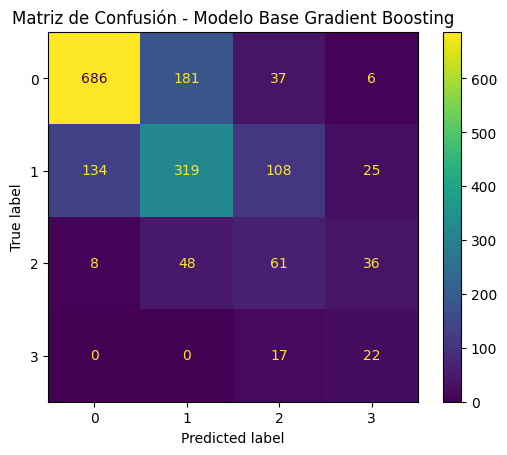

In [35]:
# Predicciones en test
y_hat_gb = clf_gb.predict(X_test_gb)

# Classification Report
print("Reporte de Clasificaci√≥n (Modelo Base Gradient Boosting):")
print(classification_report(y_test_gb, y_hat_gb))

# Matriz de Confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_test_gb, y_hat_gb)
plt.title("Matriz de Confusi√≥n - Modelo Base Gradient Boosting")
plt.show()

Reporte de Clasificaci√≥n (Modelo Base Gradient Boosting):
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       910
           1       0.58      0.54      0.56       586
           2       0.27      0.40      0.32       153
           3       0.25      0.56      0.34        39

    accuracy                           0.64      1688
   macro avg       0.48      0.57      0.51      1688
weighted avg       0.68      0.64      0.66      1688



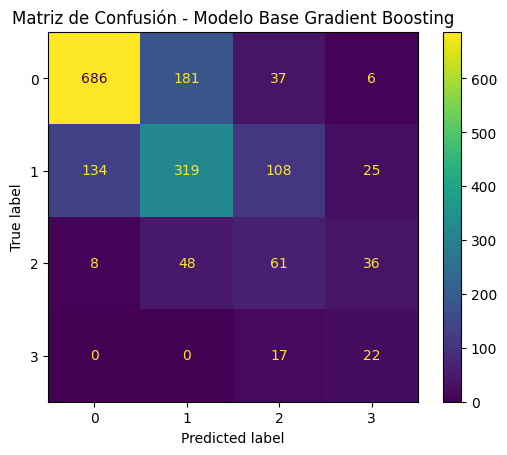

In [36]:
# Predicciones en test
y_hat_gb = clf_gb.predict(X_test_gb)

# Classification Report
print("Reporte de Clasificaci√≥n (Modelo Base Gradient Boosting):")
print(classification_report(y_test_gb, y_hat_gb))

# Matriz de Confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_test_gb, y_hat_gb)
plt.title("Matriz de Confusi√≥n - Modelo Base Gradient Boosting")
plt.show()

In [17]:
#Ajuste del modelo

# Modelo base
gb_base = HistGradientBoostingClassifier(random_state=2025)

# Grilla compacta pero efectiva
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [20, 50]
}


In [22]:
grid_search_gb = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Ejecutar b√∫squeda con sample_weight
grid_search_gb.fit(X_train_gb, y_train_gb, sample_weight=sample_weights)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=20; total time=   3.2s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=20; total time=   3.3s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=20; total time=   2.2s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   2.8s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   3.2s
[CV] END learning_rate=0.05, max_depth=None, max_iter=200, min_samples_leaf=20; total time=   5.9s
[CV] END learning_rate=0.05, max_depth=None, max_iter=200, min_samples_leaf=20; total time=   5.9s
[CV] END learning_rate=0.05, max_depth=None, max_iter=200, min_samples_leaf=20; total time=   5.0s
[CV] END learning_rate=0.05, max_depth=None, max_iter=200, min_samples_leaf=50; total time=   5.2s
[CV] END l

GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(random_state=2025),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [None, 10, 20], 'max_iter': [100, 200],
                         'min_samples_leaf': [20, 50]},
             scoring='f1_macro', verbose=2)

In [23]:
best_clf_gb = grid_search_gb.best_estimator_
print("Mejores hiperpar√°metros encontrados:")
print(grid_search_gb.best_params_)

Mejores hiperpar√°metros encontrados:
{'learning_rate': 0.1, 'max_depth': None, 'max_iter': 200, 'min_samples_leaf': 20}


In [24]:
# Predicciones sobre el test set
y_hat_best_gb = best_clf_gb.predict(X_test_gb)

# Reporte de clasificaci√≥n
print("Reporte de Clasificaci√≥n (Modelo Optimizado Gradient Boosting):")
print(classification_report(y_test_gb, y_hat_best_gb))

# Matriz de confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_test_gb, y_hat_best_gb)
plt.title("Matriz de Confusi√≥n - Modelo Optimizado Gradient Boosting")
plt.show()

Reporte de Clasificaci√≥n (Modelo Optimizado Gradient Boosting):
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       910
           1       0.58      0.54      0.56       586
           2       0.27      0.40      0.32       153
           3       0.25      0.56      0.34        39

    accuracy                           0.64      1688
   macro avg       0.48      0.57      0.51      1688
weighted avg       0.68      0.64      0.66      1688



#### Random Forest

In [ ]:
# Variables
categorical_cols = ['month', 'state', 'region', 'season']
numeric_cols = ['start_latitude', 'start_longitude', 'length', 'width']
target = 'magnitude'

# Features y target
features_rf = categorical_cols + numeric_cols
target_rf = target

# Copias de trabajo
X_train_rf = df_train[features_rf].copy()
X_test_rf = df_test[features_rf].copy()

y_train_rf = df_train[target_rf].copy()
y_test_rf = df_test[target_rf].copy()

# One-hot encoding para las variables categ√≥ricas (eliminar la primera para evitar multicolinealidad)
X_train_rf = pd.get_dummies(X_train_rf, columns=categorical_cols, drop_first=True)
X_test_rf = pd.get_dummies(X_test_rf, columns=categorical_cols, drop_first=True)

# Label encoding para la variable objetivo
label_encoder_rf = LabelEncoder()
y_train_enc_rf = label_encoder_rf.fit_transform(y_train_rf)
y_test_enc_rf = label_encoder_rf.transform(y_test_rf)

In [39]:
# Entrenar modelo base con pesos balanceados
clf_rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=30,
    n_estimators=100,
    random_state=2025
)

clf_rf.fit(X_train_rf, y_train_enc_rf)

RandomForestClassifier(class_weight='balanced', max_depth=30, random_state=2025)

Accuracy (modelo base RF): 69.25%
F1 Score Macro (modelo base RF): 50.18%

Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       910
           1       0.59      0.61      0.60       586
           2       0.39      0.20      0.27       153
           3       0.56      0.23      0.33        39

    accuracy                           0.69      1688
   macro avg       0.58      0.47      0.50      1688
weighted avg       0.67      0.69      0.68      1688



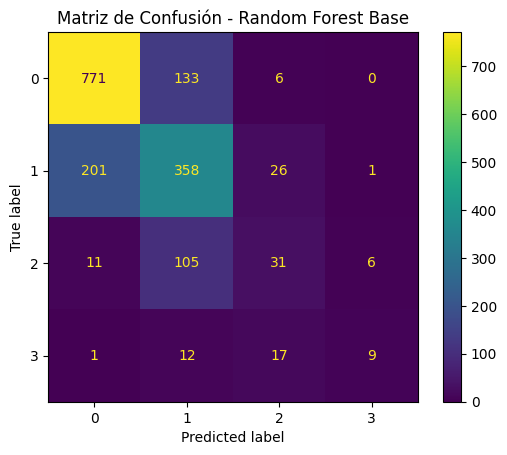

In [45]:
# Predicciones sobre el test set
y_hat_rf = clf_rf.predict(X_test_rf)

# Accuracy y F1 Score
print(f"Accuracy (modelo base RF): {accuracy_score(y_test_enc_rf, y_hat_rf) * 100:.2f}%")
print(f"F1 Score Macro (modelo base RF): {f1_score(y_test_enc_rf, y_hat_rf, average='macro') * 100:.2f}%")

# Reporte de clasificaci√≥n completo
print("\nReporte de Clasificaci√≥n:")
print(classification_report(y_test_enc_rf, y_hat_rf))

# Matriz de Confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_test_enc_rf, y_hat_rf)
plt.title("Matriz de Confusi√≥n - Random Forest Base")
plt.show()


In [46]:
# Definir la grilla de hiperpar√°metros
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Crear el modelo base
rf_base = RandomForestClassifier(class_weight='balanced', random_state=2025)

# GridSearch con 3-fold cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,  # Usa todos los n√∫cleos disponibles
    verbose=1
)

# Ejecutar GridSearch
grid_search_rf.fit(X_train_rf, y_train_enc_rf)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=2025),
             n_jobs=-1,
             param_grid={'max_depth': [10, 30, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300]},
             scoring='f1_macro', verbose=1)

In [47]:
print("Mejores hiperpar√°metros encontrados:")
print(grid_search_rf.best_params_)

Mejores hiperpar√°metros encontrados:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [48]:
# Entrenar el modelo optimizado con los mejores hiperpar√°metros
best_clf_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    class_weight='balanced',
    random_state=2025
)

best_clf_rf.fit(X_train_rf, y_train_enc_rf)

# Evaluar en el conjunto de prueba
y_hat_best_rf = best_clf_rf.predict(X_test_rf)

# Resultados
print("üîç Resultados con el modelo Random Forest optimizado")
print(classification_report(y_test_enc_rf, y_hat_best_rf))

# Matriz de Confusi√≥n
ConfusionMatrixDisplay.from_predictions(y_test_enc_rf, y_hat_best_rf)
plt.title("Matriz de Confusi√≥n - Random Forest Optimizado")
plt.show()


üîç Resultados con el modelo Random Forest optimizado
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       910
           1       0.61      0.61      0.61       586
           2       0.38      0.36      0.37       153
           3       0.37      0.36      0.36        39

    accuracy                           0.70      1688
   macro avg       0.54      0.54      0.54      1688
weighted avg       0.69      0.70      0.69      1688



In [50]:
with open("best_clf_rf.pkl", "wb") as file:
    pickle.dump(best_clf_rf, file)

#### Comparaci√≥n de Reportes

In [49]:
from IPython.display import Markdown, display

comparative_report = """
### üìä Comparaci√≥n de Modelos de Clasificaci√≥n para Predicci√≥n de Magnitud de Tornados

| Modelo                 | Accuracy | F1-Score (Macro) | Ventajas                                                       | Desventajas                                                 |
|------------------------|----------|------------------|----------------------------------------------------------------|-------------------------------------------------------------|
| **LSTM**               | 0.46     | 0.24             | Captura secuencias temporales y relaciones espaciales complejas | Bajo rendimiento general, especialmente en clases minoritarias |
| **Gradient Boosting**  | 0.64     | 0.51             | Buen manejo de datos no lineales, r√°pido de entrenar            | Baja precisi√≥n para clases minoritarias                    |
| **Random Forest**      | 0.70     | 0.54             | Precisi√≥n general m√°s alta, robusto y f√°cil de interpretar       | Menor capacidad para captar secuencias o patrones temporales|

üîç **Observaci√≥n Final**: El modelo **Random Forest optimizado** sigue siendo el m√°s robusto para esta tarea. El **LSTM** no logr√≥ generalizar bien en el conjunto de prueba, especialmente con clases desbalanceadas.

üìå Recomendaci√≥n: Usar **Random Forest** para despliegue inicial en Streamlit, mientras se exploran mejoras o versiones refinadas del modelo LSTM.
"""

display(Markdown(comparative_report))



### üìä Comparaci√≥n de Modelos de Clasificaci√≥n para Predicci√≥n de Magnitud de Tornados

| Modelo                 | Accuracy | F1-Score (Macro) | Ventajas                                                       | Desventajas                                                 |
|------------------------|----------|------------------|----------------------------------------------------------------|-------------------------------------------------------------|
| **LSTM**               | 0.46     | 0.24             | Captura secuencias temporales y relaciones espaciales complejas | Bajo rendimiento general, especialmente en clases minoritarias |
| **Gradient Boosting**  | 0.64     | 0.51             | Buen manejo de datos no lineales, r√°pido de entrenar            | Baja precisi√≥n para clases minoritarias                    |
| **Random Forest**      | 0.70     | 0.54             | Precisi√≥n general m√°s alta, robusto y f√°cil de interpretar       | Menor capacidad para captar secuencias o patrones temporales|

üîç **Observaci√≥n Final**: El modelo **Random Forest optimizado** sigue siendo el m√°s robusto para esta tarea. El **LSTM** no logr√≥ generalizar bien en el conjunto de prueba, especialmente con clases desbalanceadas.

üìå Recomendaci√≥n: Usar **Random Forest** para despliegue inicial en Streamlit, mientras se exploran mejoras o versiones refinadas del modelo LSTM.


8. Visualizacion del modelo 
9. Conclusiones y recomendaciones 

### 10. Referencias

1. National Weather Service (NWS). (n.d.). Enhanced Fujita Scale (EF Scale). NOAA.
https://www.weather.gov/oun/efscale
2. Storm Prediction Center (SPC). (n.d.). The Enhanced Fujita Scale (EF Scale). NOAA.
https://www.spc.noaa.gov/faq/tornado/ef-scale.html
3. National Centers for Environmental Information (NCEI). (n.d.). Billion-Dollar Weather and Climate Disasters. NOAA.
https://www.ncei.noaa.gov/access/billions/
4. Federal Emergency Management Agency (FEMA). (n.d.). Tornadoes | Disaster Recovery Resources.
https://www.fema.gov/disaster-recovery-resources/tornadoes

In [ ]:
#frames = []

#for i in range(1, len(df)):
#    frame_data = df.iloc[:i]
#
#    scatter = go.Scattergeo(
#        lon=frame_data['start_longitude'],
#        lat=frame_data['start_latitude'],
#        mode='markers',
#        marker=dict(
#            size=frame_data['magnitude'] * 3,
#            color=frame_data['magnitude'],
#            colorscale='YlOrRd',
#            cmin=0,
#            cmax=df['magnitude'].max(),
#            showscale=False,
#            opacity=0.7
#        ),
#        showlegend=False
#    )
#
#    frames.append(go.Frame(data=[scatter], name=str(i)))
#
#
#fig = go.Figure(
#    data=[frames[0].data[0]],
#    layout=go.Layout(
#        title='Cumulative Tornado Animation',
#        geo=dict(
#            scope='usa',
#            showland=True,
#            landcolor='rgb(217, 217, 217)',
#            subunitcolor='black',
#            showsubunits=True
#        ),
#        updatemenus=[dict(
#            type='buttons',
#            buttons=[dict(label='Play', method='animate', args=[None])]
#        )]
#    ),
#    frames=frames
#)

#fig.show()

In [12]:
df_train.to_csv("df_train.csv", index=False)

In [7]:
df.to_csv("df.csv", index=False)